In [1]:
%matplotlib inline

In [2]:
import json
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['svg.fonttype'] = 'none'

In [10]:
RAW_HASHED_DATA_ROOT = Path("C:/Users/Monthy/Documents/projects/thesis/thesis-data-suite/data/raw/hashed_lights")
RAW_ATTENUATED_DATA_ROOT = Path("C:/Users/Monthy/Documents/projects/thesis/thesis-data-suite/data/raw/forward_deferred")
RAW_TILED_DATA_ROOT = Path("C:/Users/Monthy/Documents/projects/thesis/thesis-data-suite/data/raw/tiled")

In [11]:
SCENES = { "pipers-alley" : [  "58#1x_1y_1z"
                             , "116#2x_1y_1z"
                             , "174#1x_3y_1z"                                
                             , "232#1x_2y_2z"
                             , "348#1x_2y_3z"
                             , "464#2x_2y_2z"
                             , "522#1x_3y_3z"
                             , "696#3x_2y_2z"
                             , "1044#3x_3y_2z"
                            ]
          , "ziggurat-city" : [ "65#1x_1y_1z"
                               , "130#2x_1y_1z"
                               , "195#1x_1y_3z"
                               , "260#2x_2y_1z"
                               , "390#3x_1y_2z"
                               , "520#2x_2y_2z"
                               , "585#3x_3y_1z"
                               , "780#3x_2y_2z"
                               , "1170#3x_3y_2z"
                              ]
          , "spaceship-indoor" : [ "70#1x_1y_1z"
                                  , "140#2x_1y_1z"
                                  , "210#3x_1y_1z"
                                  , "280#2x_2y_1z"
                                  , "420#3x_2y_1z"
                                  , "560#2x_2y_2z"
                                  , "630#3x_3y_1z"
                                  , "840#3x_2y_2z"
                                  , "1260#3x_3y_2z"
                                 ]
         }

N_TESTS = 3

RESOLUTION = 1920

In [12]:
def json_to_dataframe(json_dic : dict) -> pd.DataFrame:
    '''
    Convert a json data file spit out by nTiled into something just slightly more useful
    '''
    # get all functions tracked from first frame
    frames = json_dic["frames"]
    functions = list(x for x in frames[0]["functions"])
    
    # build empty dictionary which will be loaded with data from frames
    data_raw = { fn : {} for fn in functions }    
    frames_i = {}
    
    for f in frames:
        f_i = int(f["frame"])
        frames_i[f_i] = f_i
        for fn in functions:
            if fn in f["functions"]:
                data_raw[fn][f_i] = float(f["functions"][fn])
            
    data_series = {fn : pd.Series(data_raw[fn], name=fn) for fn in functions }
    data_series["index"] = pd.Series(frames_i, name="index")
    
    dataframe = pd.DataFrame(data_series)
    return dataframe

In [15]:
def extract_lights_data_frame_hashed(scene):
    folder_path = RAW_HASHED_DATA_ROOT / Path("forward/{}/".format(scene))
    
    output = pd.DataFrame([], columns=["execution_time", "n_lights"])
    
    index = 0
    
    for ld in SCENES[scene]:
        ld_path = folder_path / Path("{}".format(ld))
        n_lights = int(ld.split("#")[0])
        
        for i in range(N_TESTS):
            file_path = ld_path / Path("data_{}.json".format(i))
            
            with open(str(file_path), 'r') as f:
                data_json = json.loads(f.read())
            df = json_to_dataframe(data_json)
            output.loc[index] = [df.mean(axis=0).iloc[0], n_lights]
            index += 1
    return output

In [17]:
def extract_lights_data_frame_attenuated(scene):
    folder_path = RAW_ATTENUATED_DATA_ROOT / Path("forward/{}/".format(scene))
    
    output = pd.DataFrame([], columns=["execution_time", "n_lights"])
    
    index = 0
    
    for ld in SCENES[scene]:
        ld_path = folder_path / Path("{}/1920/".format(ld))
        n_lights = int(ld.split("#")[0])
        
        for i in range(N_TESTS):
            file_path = ld_path / Path("data_{}.json".format(i))
            
            with open(str(file_path), 'r') as f:
                data_json = json.loads(f.read())
            df = json_to_dataframe(data_json)
            output.loc[index] = [df.mean(axis=0).iloc[0], n_lights]
            index += 1
    return output

In [18]:
def extract_lights_data_frame_tiled(scene):
    folder_path = RAW_TILED_DATA_ROOT / Path("forward/{}/".format(scene))
    
    output = pd.DataFrame([], columns=["execution_time", "n_lights"])
    
    index = 0
    
    for ld in SCENES[scene]:
        ld_path = folder_path / Path("{}/1920/32/".format(ld))
        n_lights = int(ld.split("#")[0])
        
        for i in range(N_TESTS):
            file_path = ld_path / Path("data_{}.json".format(i))
            
            with open(str(file_path), 'r') as f:
                data_json = json.loads(f.read())
            df = json_to_dataframe(data_json)
            output.loc[index] = [df.mean(axis=0).iloc[0], n_lights]
            index += 1
    return output

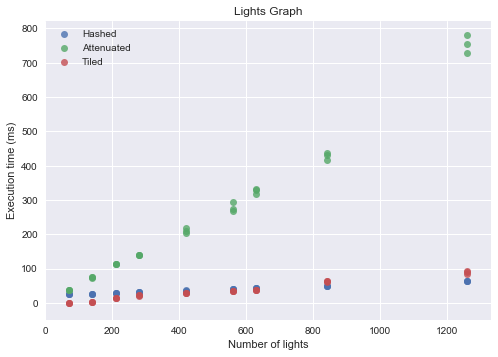

In [19]:
si_lights_hashed = extract_lights_data_frame_hashed("spaceship-indoor")
si_lights_attenuated = extract_lights_data_frame_attenuated("spaceship-indoor")
si_lights_tiled = extract_lights_data_frame_tiled("spaceship-indoor")

ax = sns.regplot("n_lights", "execution_time", 
                 data=si_lights_hashed, fit_reg=False, 
                 label="Hashed")
ax = sns.regplot("n_lights", "execution_time", 
                 data=si_lights_attenuated, fit_reg=False, 
                 label="Attenuated")
ax = sns.regplot("n_lights", "execution_time", 
                 data=si_lights_tiled, fit_reg=False, 
                 label="Tiled")

    
ax.set(xlabel='Number of lights', ylabel='Execution time (ms)')
ax.legend()         
ax.set_title("Lights Graph")
    
plt.show()

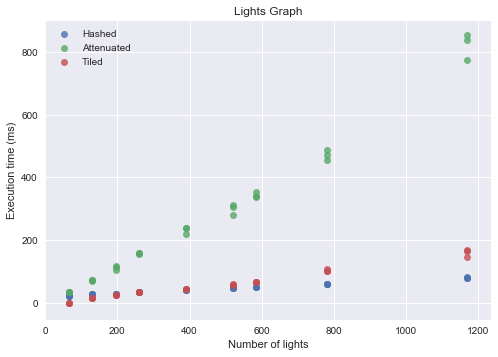

In [20]:
zc_lights_hashed = extract_lights_data_frame_hashed("ziggurat-city")
zc_lights_attenuated = extract_lights_data_frame_attenuated("ziggurat-city")
zc_lights_tiled = extract_lights_data_frame_tiled("ziggurat-city")

ax = sns.regplot("n_lights", "execution_time", 
                 data=zc_lights_hashed, fit_reg=False, 
                 label="Hashed")
ax = sns.regplot("n_lights", "execution_time", 
                 data=zc_lights_attenuated, fit_reg=False, 
                 label="Attenuated")
ax = sns.regplot("n_lights", "execution_time", 
                 data=zc_lights_tiled, fit_reg=False, 
                 label="Tiled")

    
ax.set(xlabel='Number of lights', ylabel='Execution time (ms)')
ax.legend()         
ax.set_title("Lights Graph")
    
plt.show()

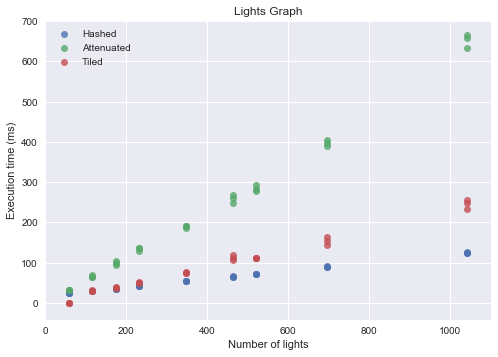

In [21]:
pa_lights_hashed = extract_lights_data_frame_hashed("pipers-alley")
pa_lights_attenuated = extract_lights_data_frame_attenuated("pipers-alley")
pa_lights_tiled = extract_lights_data_frame_tiled("pipers-alley")

ax = sns.regplot("n_lights", "execution_time", 
                 data=pa_lights_hashed, fit_reg=False, 
                 label="Hashed")
ax = sns.regplot("n_lights", "execution_time", 
                 data=pa_lights_attenuated, fit_reg=False, 
                 label="Attenuated")
ax = sns.regplot("n_lights", "execution_time", 
                 data=pa_lights_tiled, fit_reg=False, 
                 label="Tiled")

    
ax.set(xlabel='Number of lights', ylabel='Execution time (ms)')
ax.legend()         
ax.set_title("Lights Graph")
    
plt.show()